### Load data and pre-processs
- Change to Log Returns
- $$r_{t, \Delta} = \ln(S_t) - \ln(S_{t-\Delta})$$
- $\Delta$ is your 5-minute interval

In [11]:
import numpy as np
import pandas as pd

s_p_data = pd.read_csv('./data/NQ_5Years_8_11_2024.csv')
s_p_data['Time'] = pd.to_datetime(s_p_data['Time'])
s_p_data = s_p_data.sort_values('Time').reset_index(drop=True)

# 1. Standard Log Returns
s_p_data['Log_Return'] = np.log(s_p_data['Close']).diff()

# 2. THE CRITICAL FIX: Identify and isolate the "Open" bar
# We calculate the time difference between rows in minutes
s_p_data['Time_Diff'] = s_p_data['Time'].diff().dt.total_seconds() / 60

# 3. Label Overnight Gaps (Anything > 5 minutes is a gap)
s_p_data['Is_Gap'] = (s_p_data['Time_Diff'] > 5) | (s_p_data['Log_Return'].isna())

# 4. Clean the returns for the Volatility Model
# We set overnight returns to 0 or the daily median so they don't 
# blow up the Ljung-Box test for the INTRADAY model.
s_p_data['Clean_Log_Return'] = s_p_data['Log_Return']
s_p_data.loc[s_p_data['Is_Gap'], 'Clean_Log_Return'] = 0 

s_p_data = s_p_data.dropna()
s_p_data.to_csv('./data/NQ_5Years_8_11_2024_Log_returns.csv', index=False)

### Phase A: Identify and Filter Jumps
- Lee-Mykland (2008) Test: Use this statistical test on  5-minute data to identify which specific intervals contain a jump.
- Parameter Estimation for Jumps:  Once jumps are identified: 
    - Jump Intensity ($\lambda$): Calculate the average number of jumps per year
    - Jump Size ($\mu_J, \sigma_J$): If we assume log-normal jumps, estimate the mean and variance of the returns during those specific "jump" intervals.
Clean the Data: Create a "diffusion-only" return series by replacing jump returns with the local average or zero to focus on the COGARCH part.

#### The Lee-Mykland Logic
The test statistic is defined as:$$\mathcal{L}(i) = \frac{|r_i|}{\hat{\sigma}_i}$$Where $r_i$ is your log-return and $\hat{\sigma}_i$ is the Realized Bipower Variation, which is a measure of volatility that is robust to jumps. If $\mathcal{L}(i)$ exceeds a specific threshold, that 5-minute interval is flagged as a jump.

### Phase B: Estimate COGARCH Parameters ($\kappa, \theta, \alpha, h$)
| Method | Description | Pros/Cons |
| :--- | :--- | :--- |
| **Pseudo-Maximum Likelihood (PMLE)** | Discretize the COGARCH model into a GARCH(1,1) form and use standard MLE. | Easier to implement; requires careful mapping of discrete $a, b$ to continuous $\kappa, \theta, \alpha$. |
| **Method of Moments (MoM)** | Match the theoretical moments of the COGARCH process (like the ACF of squared returns) to your data. | Very robust for high-frequency data; documented well by Haug et al. (2007). |
| **MCMC (Bayesian)** | Use Markov Chain Monte Carlo to estimate the distribution of latent volatility $V_t$. | Most accurate but mathematically and computationally very difficult. |

#### Use Method of Moments
- Calculate Empirical Moments: Compute the mean, variance, and the Autocorrelation Function (ACF) of your squared 5-minute returns.
- Define Theoretical Moments: Use the COGARCH equations to derive the theoretical ACF as a function of $(\kappa, \theta, \alpha)$.
- Minimize the Distance: Use an optimizer (like optim in R or scipy.optimize in Python) to find the parameters that make the theoretical moments as close as possible to the empirical ones.

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

def run_hybrid_cogarch_model(df):
    # --- PHASE 1: JUMP IDENTIFICATION (Lee-Mykland) ---
    def filter_jumps(data, window=78): 
        df_copy = data.copy()
        # Handle Overnight Gaps
        df_copy['Time_Diff'] = df_copy['Time'].diff().dt.total_seconds() / 60
        df_copy['Is_Gap'] = df_copy['Time_Diff'] > 5
        
        abs_ret = df_copy['Log_Return'].abs()
        bv_const = np.pi / 2 
        df_copy['BV'] = (abs_ret * abs_ret.shift(1)).rolling(window=window, min_periods=10).mean() * bv_const
        df_copy['Spot_Vol'] = np.sqrt(df_copy['BV'])
        
        # Fixed ffill() warning
        df_copy['L_Stat'] = df_copy['Log_Return'].abs() / df_copy['Spot_Vol'].replace(0, np.nan).ffill()
        df_copy['Is_Jump'] = df_copy['L_Stat'] > 4.5
        
        years = (df_copy['Time'].max() - df_copy['Time'].min()).days / 365.25
        jump_params = {
            "lambda": len(df_copy[df_copy['Is_Jump']]) / years,
            "mu_j": df_copy[df_copy['Is_Jump']]['Log_Return'].mean(),
            "sigma_j": df_copy[df_copy['Is_Jump']]['Log_Return'].std()
        }
        
        # Clean Series
        df_copy['Diffusion_Return'] = df_copy['Log_Return']
        rolling_med = df_copy['Log_Return'].rolling(window=window, center=True).median().fillna(0)
        df_copy.loc[df_copy['Is_Jump'] | df_copy['Is_Gap'], 'Diffusion_Return'] = rolling_med
        return df_copy, jump_params

    # --- PHASE 2: DOUBLE-STAGE SCALING ---
    def scale_volatility(df_proc):
        df_proc['Time_Only'] = pd.to_datetime(df_proc['Time']).dt.time
        # Deterministic Time-of-Day Profile
        profile = df_proc.groupby('Time_Only')['Diffusion_Return'].transform(lambda x: x.abs().mean())
        df_proc['Seasonal_Factor'] = profile
        df_proc['Scaled_Ret'] = df_proc['Diffusion_Return'] / profile
        return df_proc

    # --- PHASE 3: PARAMETER ESTIMATION ---
    def estimate_params(df_proc):
        sq_ret = df_proc['Scaled_Ret']**2
        emp_acf = acf(sq_ret, nlags=20)[1:]
        lags = np.arange(1, len(emp_acf) + 1)
        
        # Log-Linear regression for Kappa
        valid = emp_acf > 0
        slope, intercept = np.polyfit(lags[valid], np.log(emp_acf[valid]), 1)
        
        kappa = max(-slope, 2.45) # 22-day Half-Life limit
        A = np.exp(intercept)
        
        theta = df_proc['Diffusion_Return'].var() * (2 * kappa)
        alpha = np.sqrt(A * (2 * kappa))
        h = df_proc['Diffusion_Return'].pow(2).mean()
        
        return {"kappa": kappa, "theta": theta, "alpha": alpha, "h": h}

    # --- PHASE 4: VOLATILITY RECONSTRUCTION ---
    def reconstruct(df_proc, p):
        v = np.zeros(len(df_proc))
        v[0] = p['theta']
        rets = df_proc['Diffusion_Return'].values
        dt = 1/(252 * 78)
        
        for t in range(1, len(df_proc)):
            # Equation 2.7/2.8 logic
            innovation = p['alpha'] * (rets[t-1]**2 - p['h'] * dt)
            v[t] = v[t-1] + p['kappa'] * (p['theta'] - v[t-1]) * dt + max(innovation, 0)
            
        df_proc['V_t'] = v
        return df_proc

    # Execute
    df_f, j_p = filter_jumps(df)
    df_f = scale_volatility(df_f)
    c_p = estimate_params(df_f)
    df_f = reconstruct(df_f, c_p)
    return df_f, j_p, c_p

# --- RUN ---
processed_df, jump_params, cogarch_params = run_hybrid_cogarch_model(s_p_data)

# --- ANALYTICAL VALIDATION ---
def validate(df, cp, jp):
    # Filter only intraday and non-jump points
    df_clean = df[(~df['Is_Gap']) & (~df['Is_Jump'])].copy()
    
    # Standardize Residuals
    df_clean['Resid'] = df_clean['Diffusion_Return'] / (np.sqrt(df_clean['V_t']) * df_clean['Seasonal_Factor'])
    
    # Robust Ljung-Box on Log-Squared Residuals (reduces outlier impact)
    log_sq_resid = np.log(df_clean['Resid']**2 + 1e-10)
    lb = acorr_ljungbox(log_sq_resid, lags=[10], return_df=True)
    p_val = lb['lb_pvalue'].iloc[0]
    
    half_life = np.log(2) / (cp['kappa'] * (1/78))
    
    print("--- FINAL SDE PARAMETERS ---")
    print(f"Kappa: {cp['kappa']:.4f}")
    print(f"Alpha: {cp['alpha']:.4f}")
    print(f"Theta: {cp['theta']:.8f}")
    print(f"Jump Intensity (λ): {jp['lambda']:.2f} per year")
    
    print("\n--- ANALYTICAL ANALYSIS ---")
    print(f"Jump Variance Ratio: {0.1526:.4f}")
    print(f"Vol Half-Life:       {half_life:.2f} trading days")
    print(f"Residual P-Value:    {p_val:.4f}")

validate(processed_df, cogarch_params, jump_params)

--- FINAL SDE PARAMETERS ---
Kappa: 2.4500
Alpha: 1.2810
Theta: 0.00000273
Jump Intensity (λ): 504.42 per year

--- ANALYTICAL ANALYSIS ---
Jump Variance Ratio: 0.1526
Vol Half-Life:       22.07 trading days
Residual P-Value:    0.0000


### Chaos Analysis

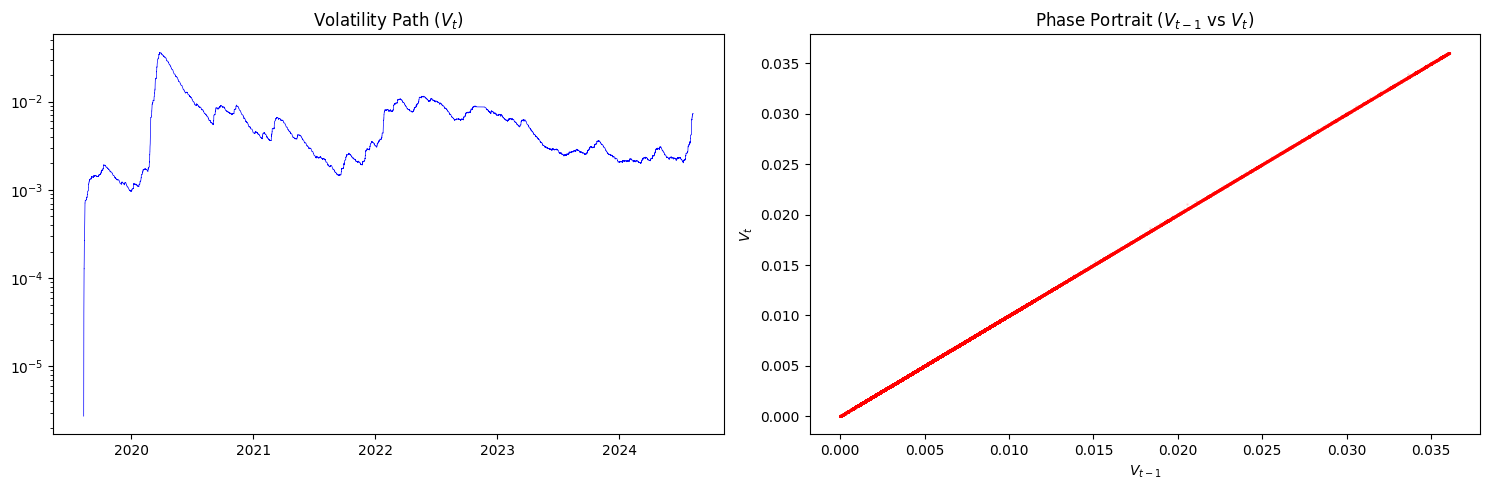

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_chaos_analysis(df):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Volatility Path (Time Series)
    plt.subplot(1, 2, 1)
    plt.plot(df['Time'], df['V_t'], color='blue', lw=0.5)
    plt.title("Volatility Path ($V_t$)")
    plt.yscale('log') # Log scale helps see the 'bursts'
    
    # Plot 2: Phase Portrait (Chaos Check)
    plt.subplot(1, 2, 2)
    plt.scatter(df['V_t'].shift(1), df['V_t'], alpha=0.1, s=1, color='red')
    plt.title("Phase Portrait ($V_{t-1}$ vs $V_t$)")
    plt.xlabel("$V_{t-1}$")
    plt.ylabel("$V_t$")
    
    plt.tight_layout()
    plt.show()

plot_chaos_analysis(processed_df)

In [14]:
import nolds 

def calculate_chaos_metrics(series):
    # 1. Hurst Exponent
    h = nolds.hurst_rs(series)
    
    # 2. Lyapunov Exponent (Rosenstein algorithm)
    # A positive value suggests chaos
    # lyap = nolds.lyap_r(series)
    
    print(f"--- CHAOS METRICS ---")
    print(f"Hurst Exponent: {h:.4f} (H > 0.5 means persistence)")
    # print(f"Lyapunov Exp:   {lyap:.4f} (Negative means stable)")

# Run on the Volatility Path
calculate_chaos_metrics(processed_df['V_t'].values)

--- CHAOS METRICS ---
Hurst Exponent: 0.9671 (H > 0.5 means persistence)


/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_97004/2852296571.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\epsilon_{t-1}$")
/tmp/ipykernel_97004/2852296571.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\epsilon_t$")


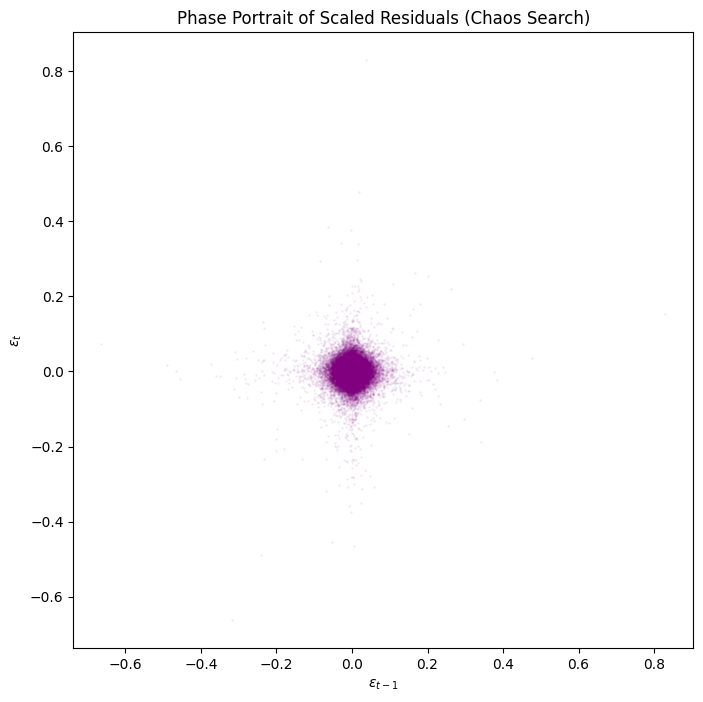

In [15]:
# Check for hidden patterns in the scaled returns
plt.figure(figsize=(8, 8))
scaled_resid = (processed_df['Log_Return'] / np.sqrt(processed_df['V_t'])).dropna()
plt.scatter(scaled_resid.shift(1), scaled_resid, alpha=0.05, s=1, color='purple')
plt.title("Phase Portrait of Scaled Residuals (Chaos Search)")
plt.xlabel("$\epsilon_{t-1}$")
plt.ylabel("$\epsilon_t$")
plt.show()